The quality of synthetic data is paramount to that of the trained model.

In [16]:
import numpy as np
import scipy
from scipy import interpolate, constants, stats
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
import time
from functools import partial
from pathlib import Path
import jax
from jax import vmap, jit
from jax import numpy as jnp
from flax import linen as nn
from flax.training import train_state
import astropy
from astropy import coordinates as coord
from astropy import units as u
import optax
import orbax.checkpoint as ocp

Make sure to set the following configurations correctly.

In [17]:
DATA_DIR = Path("../data")
CKPT_DIR = Path("/checkpoints")

Some Jax settings are set below.

In [18]:
jax.config.update("jax_debug_nans", True)
jax.config.update("jax_traceback_filtering", "off")
cpu_device = jax.devices("cpu")[0]

In [19]:
planet_specs = jnp.load(DATA_DIR / "planet_specs_train.npy")
planet_profs = jnp.load(DATA_DIR / "planet_profs_train.npy")


planet_specs_train, planet_specs_validation, _, _ = train_test_split(planet_specs, planet_profs, test_size=0.5, random_state=55, stratify=planet_profs)

Since planet light isn't separated from starlight, the planet spectrum will be expressed in units of stellar flux. The spectral exitance of the star will be approximated as that of a blackbody using Planck's law.

It can be noted from the values in the vertical axis of the graph below that the flux coming from the planet is much dimmer than that coming from the star.

Parameters for the HD 209458 planetary system are [available](https://exoplanetarchive.ipac.caltech.edu/overview/HD%20209458). Within some margin of error, the star has a radius of $1.20 R_\odot$ and a temperature of $6070 K$, while its planet, HD 209458b, has a radius of $1.41 R_{Jup}$.

Planck's law, expressed for spectral exitance, is the following:

$$I_T(\lambda)=\frac{2 \cdot \pi \cdot h \cdot c^2}{\lambda^5 \cdot (e^{\frac{h \cdot c}{\lambda \cdot k_B \cdot T}}-1)}$$

The orbital speed of the planet has been computed as 145.9 km/s.

In [20]:
orb_speed = 145.9
prim_vel = jnp.load(DATA_DIR / "rvel.npy")
wlen_regr = jnp.load(DATA_DIR / "wlen_out.npy")
spec = jnp.load(DATA_DIR / "algn.npy")

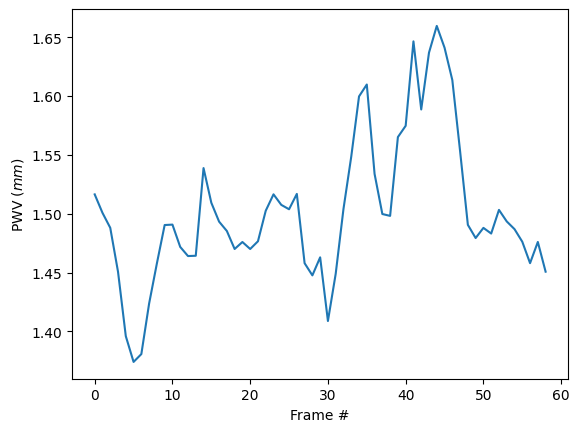

In [82]:
def gen_process_callback(key, size, p):
	with jax.default_device(cpu_device):
		random = jax.random.normal(key, shape=(size,))
		v = random[0] / jnp.sqrt(1 - p ** 2)
	sequence = np.empty(size, dtype=np.float32)
	sequence[0] = v
	for i in range(1, size):
		v = v * p + random[i]
		sequence[i] = v
	sequence = jnp.asarray(sequence)
	sequence *= jnp.sqrt(1 - p ** 2)
	return sequence

def gen_process(key, size, p):
	out_type = jax.ShapeDtypeStruct((size,), jnp.float32)
	return jax.pure_callback(gen_process_callback, out_type, key, size, p)

def gen_pwv_seq(key, size, dt=1, pace=6e5, s=0.69598, scale=3.0862):
	pace /= dt
	p = pace / (pace + 1)
	sequence = gen_process(key, size, p)
	sequence *= s
	pwv_seq = jnp.exp(sequence)
	pwv_seq *= scale
	return pwv_seq

timespan = 5 * 60 * 60

key = jax.random.PRNGKey(44)

key, pwv_key = jax.random.split(key)

pwv_seq = gen_pwv_seq(pwv_key, 59, dt=timespan / 59)

plt.plot(pwv_seq)
plt.xlabel("Frame #")
plt.ylabel("PWV ($mm$)")
plt.show()

The following code creates and displays a synthetic planetary signal.

The observed planet emits a spectrum which depends on the composition of its atmosphere. This is then subject to a Doppler shift determined by the radial component, towards or away from the Earth, of the velocity of the planet.

The planetary radial velocity is determined mostly by its phase along its circular orbit around the star, which is approximated as having a right-angle line-of-sight inclination, and, to a lesser extent, by the stellar primary (systemic and barycentric) velocity.

Each image shown corresponds to an order of the planetary signal. The vertical axis represents time and orbital phase. The horizontal axis represents wavelengths and, thus, covers different values for each order. The lines of the planetary signal are tilted and somewhat curved due to the radial velocity (and therefore Doppler shift) varying over time.

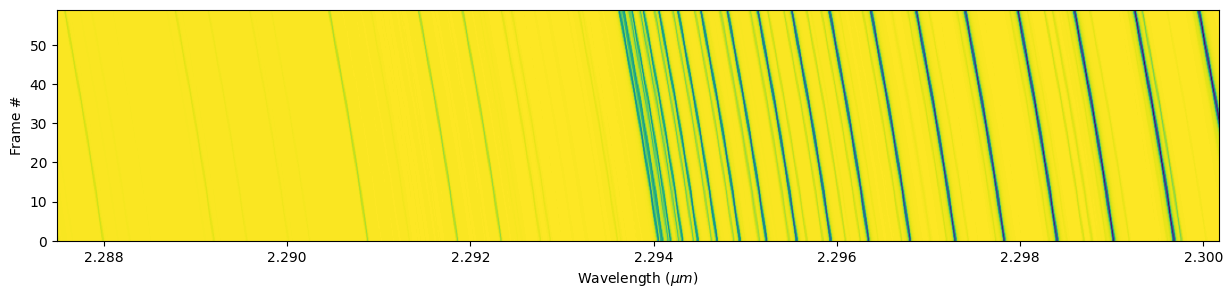

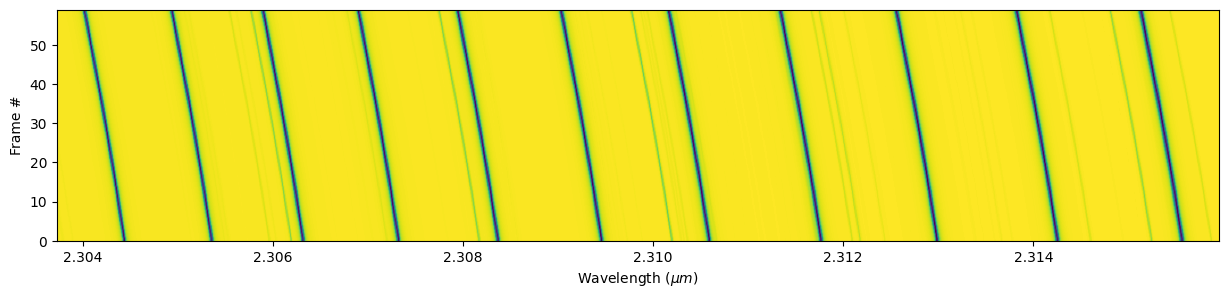

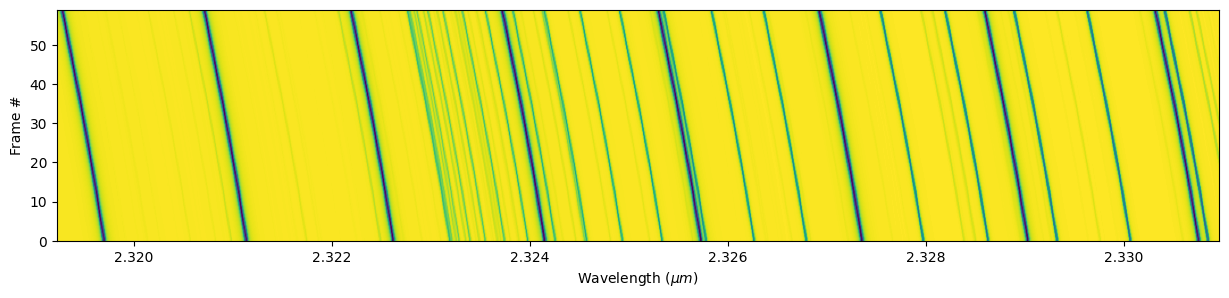

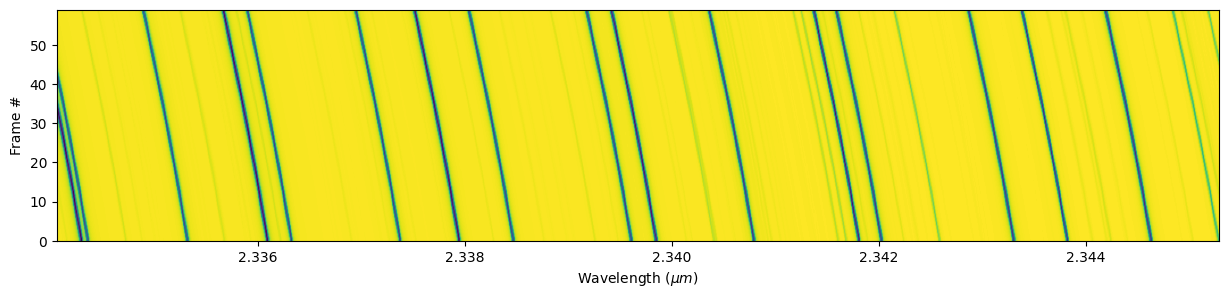

0

In [102]:
def gen_res_seq(key, size, dt=1, pace=0, s=0.3738915915678509, scale=17761.63671423916):
	pace /= dt
	p = pace / (pace + 1)
	seq = gen_process(key, size, p)
	seq *= s
	seq = jnp.exp(seq)
	seq = 100000 - scale * seq
	return seq

def get_gaussian_ip(res, wres):
	assert res.ndim == 1

	fwhm = wres / res
	sigma = fwhm / (2 * jnp.sqrt(2 * jnp.log(2)))
	hker = 32
	xker = jnp.arange(-hker, hker + 1)
	yker = jnp.exp(-(xker[*([None] * res.ndim)] / sigma[..., None]) ** 2 / 2)
	yker /= yker.sum(axis=-1, keepdims=True)
	return yker, hker

def broaden_spectra(specs, wlen, res):
	assert specs.ndim >= 1
	assert wlen.ndim >=1
	assert res.ndim == 1
	assert specs.shape[-1] == wlen.shape[-1]

	lam_pix = (wlen[1:] + wlen[:-1]) / 2
	dlam_pix = wlen[1:] - wlen[:-1]
	dv_pix = jnp.mean(dlam_pix / lam_pix)
	ker, hk = get_gaussian_ip(res, dv_pix)
	convolve = jax.tree_util.Partial(jnp.convolve, mode="valid")
	for _ in range(ker.ndim - specs.ndim):
		convolve = vmap(convolve, in_axes=(None, 0))
	for _ in range(specs.ndim - ker.ndim):
		convolve = vmap(convolve, in_axes=(0, None))
	for _ in range(specs.ndim - 1):
		convolve = vmap(convolve, in_axes=(0, 0))
	specs_broad = convolve(specs, ker)
	return wlen[hk : -hk], specs_broad

ph_offset = 0.07106706

def gen_ph_seqs(key, num, n_frames=59, ph_0_min=0.35, ph_0_max=0.65):
	ph_0 = jax.random.uniform(key, shape=(num,), minval=ph_0_min, maxval=ph_0_max - ph_offset)
	ph = jnp.linspace(ph_0, ph_0 + ph_offset, num=n_frames).T
	return ph

def gen_wobble_seq(key, num):
	wobble_seq = gen_process(key, num, 0.9) * 0.1
	return wobble_seq

def create_planet_sign_callback(spec, wlen, ph_seq, prim_vel_seq, orb_speed, wobble_seq, res_seq):
	assert spec.ndim == wlen.ndim == prim_vel_seq.ndim == ph_seq.ndim == wobble_seq.ndim == res_seq.ndim == 1
	assert spec.size == wlen.size
	assert ph_seq.size == prim_vel_seq.size == wobble_seq.size == res_seq.size

	wlen_broad, specs_broad = broaden_spectra(spec, wlen, res_seq)
	no, nx = wlen_regr.shape
	n_frames = ph_seq.size
	vel = prim_vel_seq + orb_speed * jnp.sin(2 * jnp.pi * ph_seq) + wobble_seq
	planet_sign = np.ones((no, n_frames, nx), dtype=np.float32)
	c = constants.speed_of_light
	shift = 1 - vel * 1000 / c
	for j in range(n_frames):
		cs = interpolate.splrep(wlen_broad, specs_broad[j])
		for io in range(no):
			shifted_wlen = wlen_regr[io] * shift[j]
			planet_sign[io, j] += interpolate.splev(shifted_wlen, cs)
	planet_sign = jnp.asarray(planet_sign)
	return planet_sign

def create_planet_sign(spec, wlen, ph_seq, prim_vel_seq, orb_speed, wobble_seq, res_seq):
	no, nx = wlen_regr.shape
	n_frames = ph_seq.size
	out_type = jax.ShapeDtypeStruct((no, n_frames, nx), jnp.float32)
	return jax.pure_callback(create_planet_sign_callback, out_type, spec, wlen, ph_seq, prim_vel_seq, orb_speed, wobble_seq, res_seq)

def plot_sign(wlen_regr, signal):
	no, nf, nx = signal.shape
	v0 = signal.min()
	v1 = signal.max()
	for io in range(no):
		plt.figure(figsize=(15, 3))
		plt.imshow(signal[io], origin="lower", aspect="auto", extent=[wlen_regr[io, 0] / 1000, wlen_regr[io, -1] / 1000, 0, nf])
		plt.xlabel(r"Wavelength ($\mu m$)")
		plt.ylabel("Frame #")
		plt.show()
	return 0

ph_key, wobble_key = jax.random.split(key)

ph_seq = jnp.linspace(0.50673796, 0.57780502, num=59)
ph_seq = gen_ph_seqs(ph_key, 1)[0]
wobble_seq = gen_wobble_seq(wobble_key, ph_seq.size)

spec_wlen = jnp.load(DATA_DIR / "common_lambda.npy") * 1000

res_seq = jnp.asarray(gen_res_seq(key, ph_seq.size))
planet_sign = create_planet_sign(planet_specs_train[0], spec_wlen, ph_seq, prim_vel, orb_speed, wobble_seq, res_seq)
plot_sign(wlen_regr, planet_sign)

As light from the observed planetary system traverses the terrestrial atmosphere to reach the telescope, some of it is absorbed or scattered. This phenomenon needs to be modelled in order to generate synthetic observations.

Precipitable water vapor is the amount of water vapor in a column of air, expressed as its height if it were condensed. In the wavelength range of interest, atmospheric extinction is dominated by molecular absorption, which is affected by PVW values.

The code below models a PVW sequence as a Markov process and displays it in a graph.

Airmass is a measure of the amount of air along the line of sight when observing a celestial source from below Earth's atmosphere. Airmass levels significantly affect atmospheric absorption, which will be lowest at zenith and highest close to the horizon.

The code below generates a sequence of airmass values and shows it in a graph.

The site of observation is set to Cerro Paranal, home to the Paranal Observatory, and its coordinates are retrieved. The zero point of right ascension is set at the March equinox for, arbitrarily, 2024.

The coordinates of the observed target are generated at random.

The first date of best visibility for the target, starting from the preset equinox, is computed. This requires a 180 degrees flip because the right ascension of the target is linked to the position of the Sun, which needs to be at nadir for optimal observations.

The starting moment of the observation is picked at random. Since the length of the night at Cerro Paranal varies between ~7h30m and ~10h, the shortest duration is used, which corresponds to an end of evening twilight at ~1am UT and start of morning twilight at ~8:30am. To fit the full 5 hours of observation before morning twilight, the observation can start anywhere between 1am UT and 3:30 UT.

The altitude of the planet at every moment during the observation is computed and converted to zenith angle relative to the observatory. Airmass levels are then computed from this.

While only one is generated below, the same code can be used to generate any number of airmass sequences, which will be useful later.

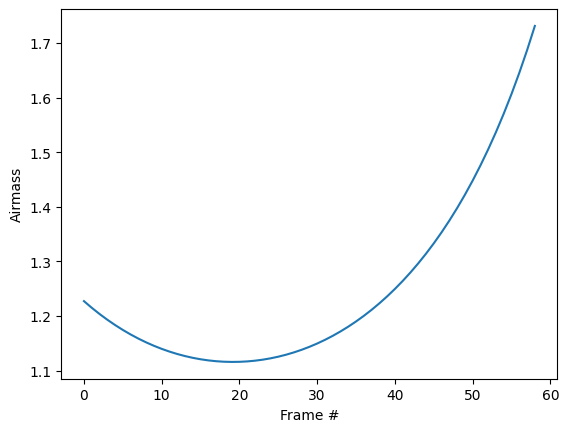

In [93]:
def gen_airmass_seqs(key, num, duration=5 * 60 * 60, n_frames=59):
	site = coord.EarthLocation.of_site("cerro paranal")
	zero_ra_ut = "2024-03-20 00:00:00"

	ra_key, dec_key, start_key = jax.random.split(key, num=3)

	with jax.default_device(cpu_device):
		targ_ra = jax.random.uniform(ra_key, shape=(num,), minval=0, maxval=360)
		targ_dec = jax.random.uniform(dec_key, shape=(num,), minval=-90, maxval=5)
		start_hour = jax.random.uniform(start_key, shape=(num,), minval=1, maxval=3.5)

	target_pos = coord.SkyCoord(unit=u.deg, ra=targ_ra, dec=targ_dec)
	targ_ra_flip = (targ_ra + 180) % 360
	opt_days_from_equinox = targ_ra_flip * 365 // 360
	opt_date = astropy.time.Time(zero_ra_ut) + opt_days_from_equinox * u.day
	start_time = opt_date + start_hour * u.hour
	target_alt = np.zeros((num, n_frames), dtype=np.float32)
	deltas = np.linspace(0, duration, num=n_frames, endpoint=False) * u.second
	for i in range(n_frames):
		obstime = start_time + deltas[i]
		target_alt_az = target_pos.transform_to(coord.AltAz(obstime=obstime, location=site))
		target_alt[:, i] = target_alt_az.alt.value

	target_alt = jnp.asarray(target_alt)
	zenith_dist = 90 - target_alt
	air = 1 / jnp.cos(jnp.pi * zenith_dist / 180)
	return air

key, air_key = jax.random.split(key)

air_seq = gen_airmass_seqs(air_key, 1)[0]

plt.plot(air_seq)
plt.xlabel("Frame #")
plt.ylabel("Airmass")
plt.show()

The code below generates and displays a multiplicative telluric transmittance signal which represents the level of atmospheric transmission for any measured wavelength at any point in time during the observation.

The telluric signal is derived from a PVW and an airmass sequence of the same duration as the observation, using a transmittance model. Telluric transmission spectra for various PWV levels and unitary airmass (corresponding to zenith) have been computed using [SkyCalc](https://www.eso.org/observing/etc/skycalc) for the spectral range between $2200 nm$ and $2400 nm$, with a fixed spectral resolution of $250000$, and merged into one file. Based on this data, the model can generate spectra for different PWV and airmass values.

To generate a random telluric signal, a PWV and an airmass sequence are generated first. The PWV sequence is discarded and generated again if, at any point, it exceeds a certain threshold. This is because observations in nights with excessive amounts of PVW are unfavorable. It should also be noted that the transmittance model wouldn't be accurate for high levels of PWV.

It can be seen that, as expected, dark columns, which correspond to high absorption, appear slightly more pronounced at the extremes of the temporal sequence (closer to the horizon) and thinner towards the middle (closer to zenith).

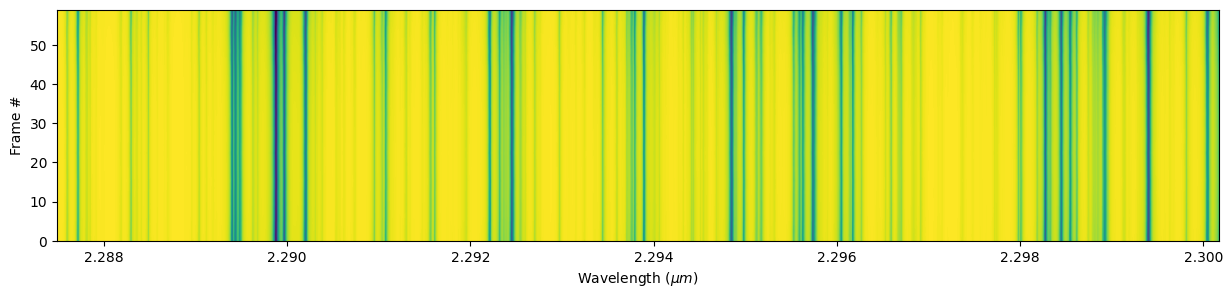

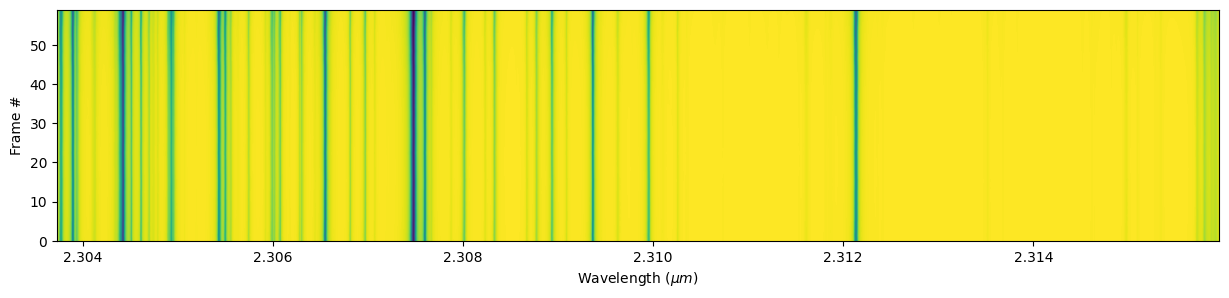

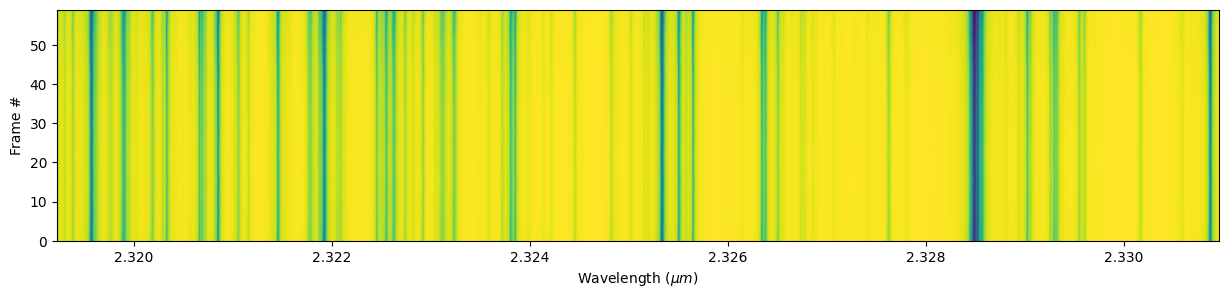

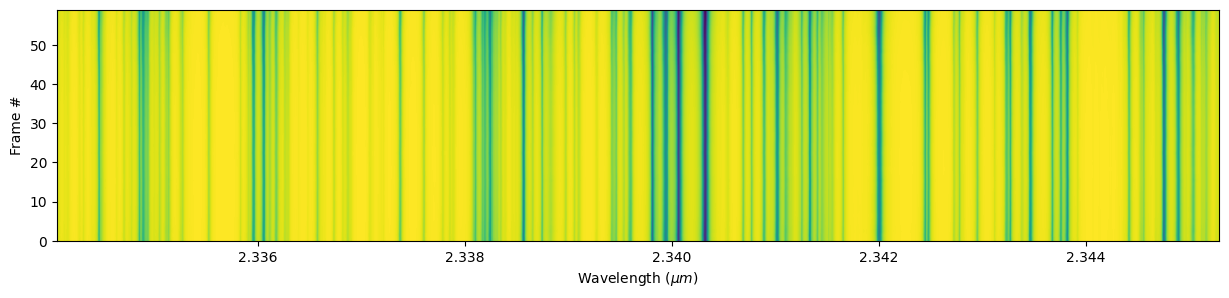

0

In [94]:
def get_tell_spectra(air_seq, pwv_seq, coeffFit):
	assert air_seq.ndim == pwv_seq.ndim == 1
	assert air_seq.size == pwv_seq.size

	pwv_fit_log = jnp.linalg.multi_dot((jnp.stack((pwv_seq, jnp.ones(pwv_seq.size)), axis=1), coeffFit))
	tel_fit_log = pwv_fit_log * air_seq[:, None]
	spec = jnp.exp(tel_fit_log)
	return spec

trans = jnp.load(DATA_DIR / "trGrid_crires.npy")
trans = trans.at[trans == 0].set(1E-20)

_, nxx = trans.shape

wmin = 2200
wmax = 2400
wres = 250000

wgrid_len = wres * (np.log(wmax / wmin))
wgrid_len = round(wgrid_len)

assert wgrid_len == nxx

wgrid = np.exp(np.arange(wgrid_len) / wres + np.log(wmin))

pwv = jnp.asarray([0.5, 1.0, 1.5, 2.5, 3.5, 5.0, 7.5, 10.0, 20.0])

grid = jnp.log(trans)

coeffFit = jnp.polyfit(pwv, grid, 1)

timespan = 5 * 60 * 60

def gen_tell_sign_callback(key, air_seq, max_pwv):
	test = True
	while test:
		key, pwv_key = jax.random.split(key)
		pwv_seq = gen_pwv_seq(pwv_key, air_seq.size, dt=timespan / air_seq.size)
		test = pwv_seq.max() > max_pwv
	shift_key, res_key = jax.random.split(key)
	wobble_seq = gen_wobble_seq(shift_key, 59)
	c = constants.speed_of_light
	shift = 1 - wobble_seq * 1000 / c
	res_seq = gen_res_seq(res_key, 59)
	specs = get_tell_spectra(air_seq, pwv_seq, coeffFit)
	wlen_broad, specs_broad = broaden_spectra(specs, wgrid, res_seq)
	tell = jnp.stack([interpolate.splev(wlen_regr * shift[i], interpolate.splrep(wlen_broad, specs_broad[i])) for i in range(59)], axis=1)
	return tell

def gen_tell_sign(key, air_seq, max_pwv=10):
	out_type = jax.ShapeDtypeStruct((wlen_regr.shape[0], 59, wlen_regr.shape[1]), jnp.float32)
	return jax.pure_callback(gen_tell_sign_callback, out_type, key, air_seq, max_pwv)

key, tell_key = jax.random.split(key)

tell_sign = gen_tell_sign(tell_key, air_seq)

sign = planet_sign * tell_sign
plot_sign(wlen_regr, sign)

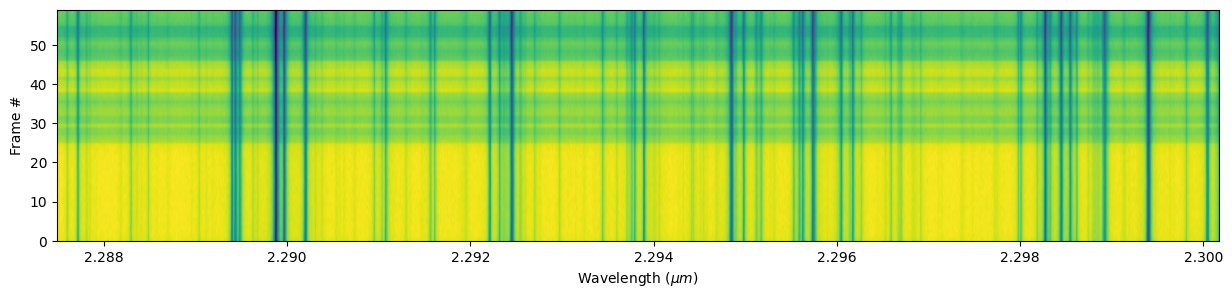

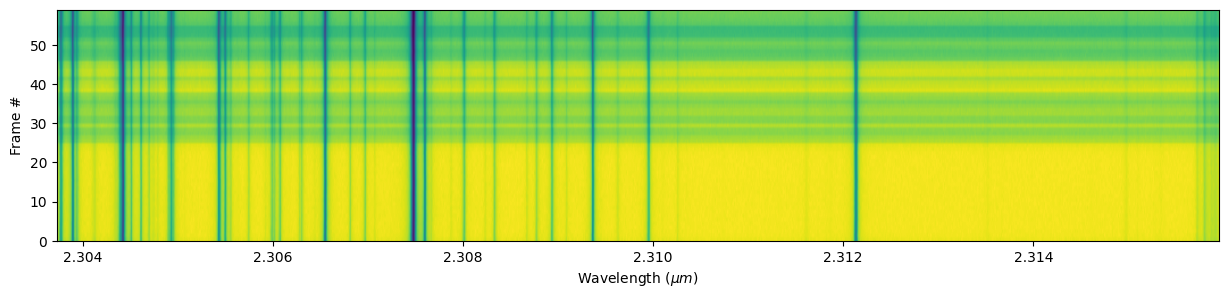

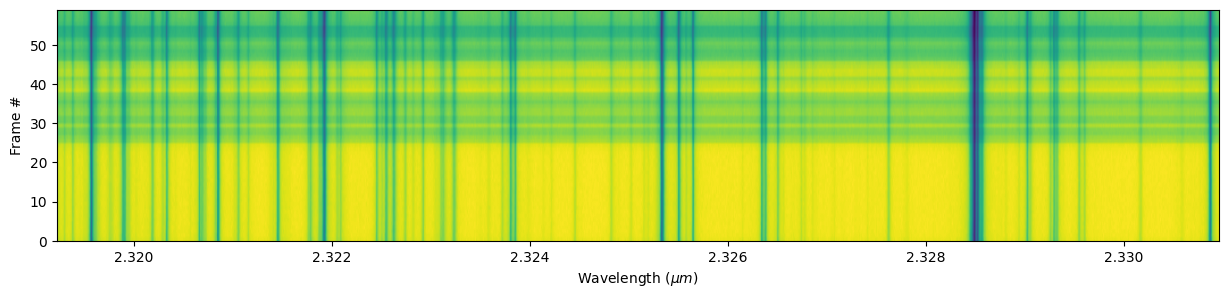

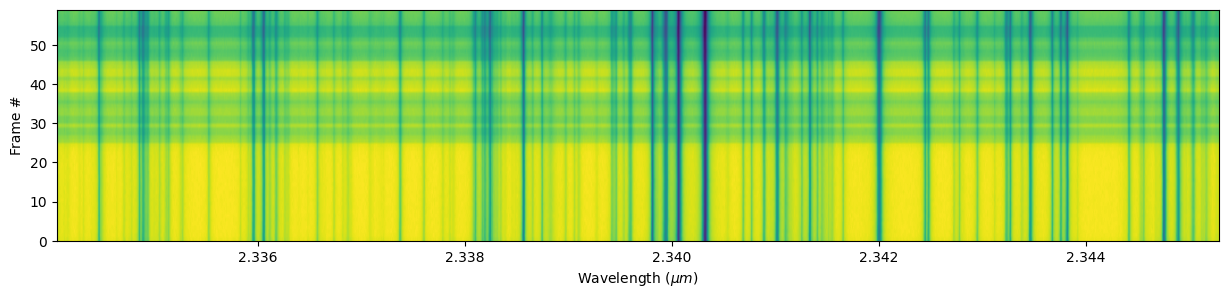

In [95]:
@partial(jit, static_argnums=1)
def gen_obs_mult_seq(key, n_frames):
	mult_seq = gen_process(key, n_frames, 0.95)
	mult_seq = jax.scipy.stats.norm.cdf(mult_seq)
	mult_seq = 0.6 + mult_seq * 0.4
	return mult_seq

vsort = jnp.sort(spec)
mult_seqs = (vsort[..., 856] + vsort[..., 857]) / 2
mult_seq = mult_seqs.mean(axis=0)
sign_ampl = mult_seq.max()
ord_mult = mult_seqs.mean(axis=1) / mult_seqs.mean()

def gen_obs_sign(key, signal):
	assert signal.ndim == 3

	exp_time = 150 * 2
	detector_gain = jnp.asarray([6.97, 6.89, 6.92, 7.27])
	obs_mult_key, noise_key, noise_fact_key = jax.random.split(key, num=3)
	obs_mult_seq = gen_obs_mult_seq(obs_mult_key, 59)
	cnt = exp_time * sign_ampl * detector_gain[:, None] * ord_mult[:, None] * obs_mult_seq[None]
	signal *= cnt[..., None]
	noise_ampl = jnp.sqrt(signal)
	noise = jax.random.normal(noise_key, shape=signal.shape)
	noise *= noise_ampl
	noise_fact = jax.random.uniform(noise_fact_key, minval=1.5, maxval=2)
	signal += noise * noise_fact
	signal /= exp_time * detector_gain[:, None, None]
	return signal

key, noise_key = jax.random.split(key)

obs_sign = gen_obs_sign(noise_key, sign)
plot_sign(wlen_regr, obs_sign)
plt.show()

The code below generates a synthetic observation.

A pool of planetary and telluric signals is generated. This can be used multiple times, improving efficiency, and can be refreshed when appropriate in order to still have enough randomness.

To synthetize an observation, a planetary and a telluric signal are selected from the available pool and noise is added.

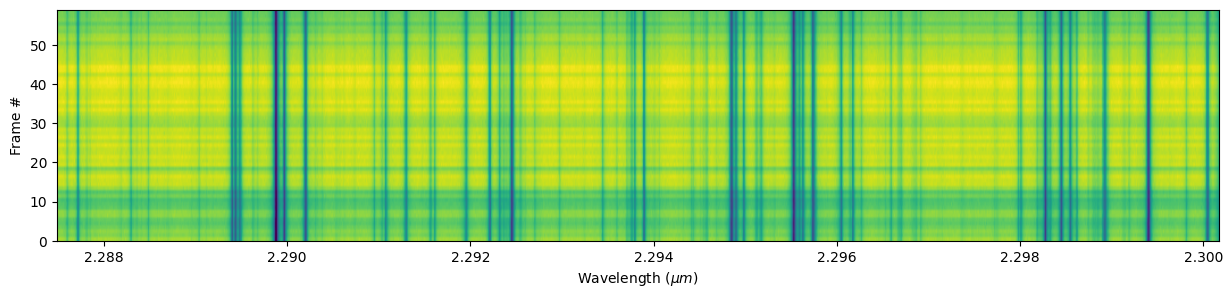

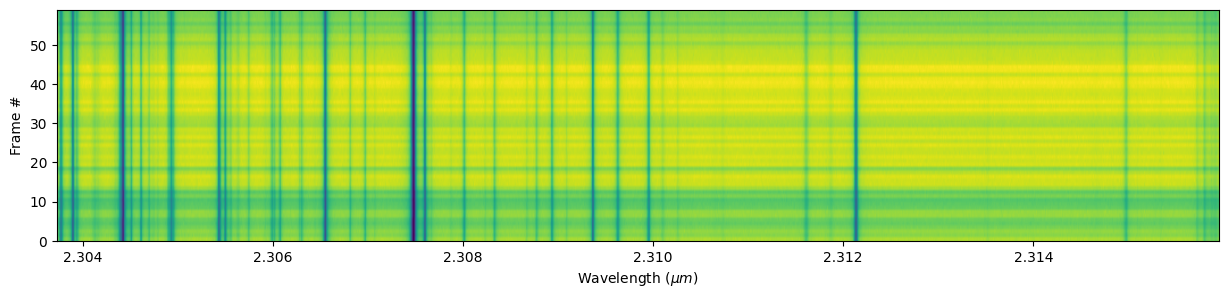

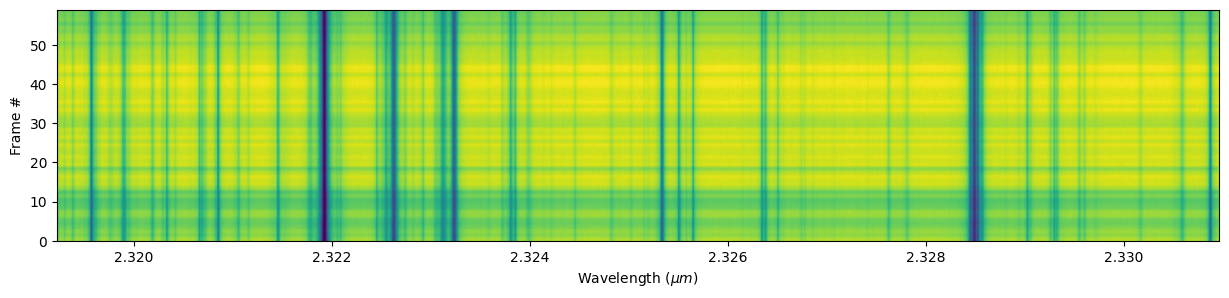

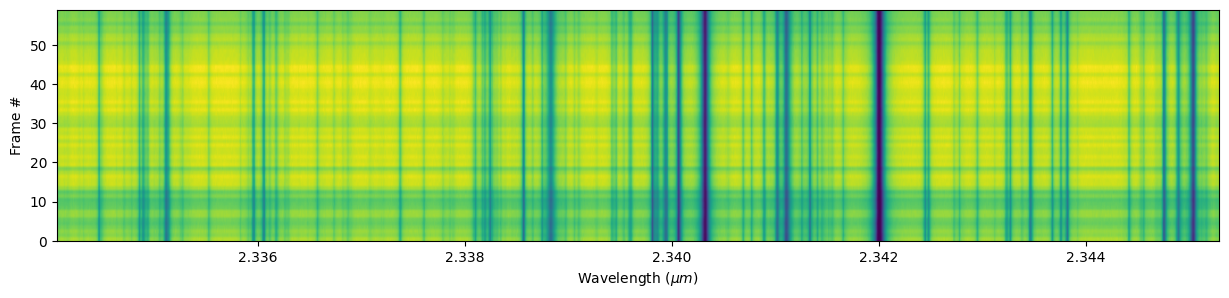

0

In [96]:
create_planet_signs = vmap(create_planet_sign, in_axes=(0, None, 0, None, None, 0, 0))
gen_wobble_seqs = vmap(gen_wobble_seq, in_axes=(0, None))
gen_res_seqs = vmap(gen_res_seq, in_axes=(0, None))

def gen_planet_signs(key, planet_specs, num=50):
	assert planet_specs.ndim == 2

	ph_key, wobble_key, specs_key, res_key = jax.random.split(key, num=4)
	ph_seqs1 = gen_ph_seqs(ph_key, num)
	ph_seqs2 = jnp.flip(ph_seqs1, axis=1)
	ph_seqs = jnp.concat((ph_seqs1, ph_seqs2))
	wobble_keys = jax.random.split(wobble_key, num=num * 2)
	wobble_seqs = gen_wobble_seqs(wobble_keys, ph_seqs.shape[1])
	specs = jax.random.choice(specs_key, planet_specs, shape=(num,))
	specs = jnp.repeat(specs, 2, axis=0)
	res_keys = jax.random.split(res_key, num=num * 2)
	res_seqs = gen_res_seqs(res_keys, ph_seqs.shape[1])
	signals = create_planet_signs(specs, spec_wlen, ph_seqs, prim_vel, orb_speed, wobble_seqs, res_seqs)
	return signals

gen_tell_sign_vmapped = vmap(gen_tell_sign, in_axes=(0, 0))

def gen_tell_signs(key, num=100):
	air_key, tell_key = jax.random.split(key)
	air_seqs = gen_airmass_seqs(air_key, num)
	tell_keys = jax.random.split(tell_key, num=num)
	tells = gen_tell_sign_vmapped(tell_keys, air_seqs)
	tells = jnp.asarray(tells)
	return tells

@jit
def gen_sign_triple(key, planet_sign_pool, tell_sign_pool):
	assert planet_sign_pool.ndim == tell_sign_pool.ndim == 4
	assert planet_sign_pool.shape[1:] == tell_sign_pool.shape[1:]

	planet_key, tell_key, noise_key = jax.random.split(key, num=3)
	planet_sign = jax.random.choice(planet_key, planet_sign_pool)
	tell_sign = jax.random.choice(tell_key, tell_sign_pool)
	sign = planet_sign * tell_sign
	obs_pos_sign = gen_obs_sign(noise_key, sign)
	obs_neg_sign = gen_obs_sign(noise_key, tell_sign)
	return obs_pos_sign, obs_neg_sign, planet_sign

key, planet_key, tell_key, sign_key = jax.random.split(key, num=4)

planet_sign_pool = gen_planet_signs(planet_key, planet_specs_train, num=2)
tell_sign_pool = gen_tell_signs(tell_key, num=2)

obs_sign, _, _ = gen_sign_triple(sign_key, planet_sign_pool, tell_sign_pool)
plot_sign(wlen_regr, obs_sign)

The code below generates a batch of training data. This determines most of what there is to know about the desired behavior of the model which will be trained.

The batch is represented as an array of inputs to and one of corresponding desired outputs from the model. A number of positive observed signals, respective planetary signals and negative observed signals is generated. From here, individual orders of each signal are processed independently.

Each input sample is a matrix representing an order of an observed signal. A planetary signal is present in half of the samples. The desired output corresponding to a positive input sample is the same order of the original planetary signal. The desired output corresponding to a negative input sample is a null matrix.

The shape of the input and of the desired output data is the same. An extra dimension of size 1 is added to both, as it will later be handy for processing. Each input sample and positive desired output is normalized so as to have a mean of 0 and a standard deviation of 1.

In [97]:
gen_sign_triples = vmap(gen_sign_triple, in_axes=(0, None, None))

def z_scores(x):
	axis = range(1, x.ndim)
	std = x.std(axis=axis, keepdims=True)
	mean = x.mean(axis=axis, keepdims=True)
	x = (x - mean) / std
	return x

@jit
def prepare_batch(pos_x, neg_x, pos_y):
	assert pos_x.ndim == neg_x.ndim == pos_y.ndim == 4
	assert pos_x[1:].shape == neg_x[1:].shape == pos_y[1:].shape
	assert pos_x.shape == pos_y.shape

	neg_y = jnp.zeros(neg_x.shape)
	x = jnp.concatenate((neg_x, pos_x))
	x = jnp.reshape(x, (-1, *x.shape[2:]))
	x = z_scores(x)
	pos_y = z_scores(pos_y)
	y = jnp.concatenate((neg_y, pos_y))
	y = jnp.reshape(y, (-1, *y.shape[2:]))
	x = x[..., None]
	y = y[..., None]
	return x, y

def gen_batch(key, num, planet_sign_pool, tell_sign_pool):
	assert planet_sign_pool.ndim == tell_sign_pool.ndim == 4
	assert planet_sign_pool.shape[1:] == tell_sign_pool.shape[1:]

	keys = jax.random.split(key, num=num)
	pos_x, neg_x, pos_y = gen_sign_triples(keys, planet_sign_pool, tell_sign_pool)
	x, y = prepare_batch(pos_x, neg_x, pos_y)
	return x, y

The loss function, the initialization and the optimizer for the model are defined below.

As a loss function, the model will use the half mean squared error. As an optimizer, the model will use Adam. Please, note that at least two versions exist in commonly used frameworks. The code belows uses the [Optax](https://optax.readthedocs.io/en/latest/api/optimizers.html#optax.adam) implementation.

In [98]:
@jit
def train_step(state, batch):
	x, y = batch
	def loss_fn(params):
		preds = state.apply_fn({ "params": params }, x)
		loss = optax.l2_loss(preds, targets=y).mean()
		return loss
	grad_fn = jax.value_and_grad(loss_fn)
	loss, grads = grad_fn(state.params)
	state = state.apply_gradients(grads=grads)
	return state, loss

def create_train_state(module, key, learning_rate):
	params = module.init(key, sign[..., None])["params"]
	tx = optax.adam(learning_rate)
	ts = train_state.TrainState.create(apply_fn=module.apply, params=params, tx=tx)
	return ts

Unlike in (typical) images, where low-level relationships among pixels are mostly localized, in each order of signals generated in this notebook significant relationships among cells exist across each line and column. These may not be easily detected by an ordinary convolutional layer.

The *Lincoln* layer, defined below, processes a three-dimensional input tensor representing a matrix of pixels with a certain depth. The corresponding output will have the same width and height as the input and a depth determined by the given hyperparameters. Each output pixel is computed, using the same weights, as the concatenation of a linear projection of its corresponding row and column in the input. The resulting tensor will, therefore, have duplicated values across each row and column.

It should be noted that the Lincoln layer independently processes a batch of samples at once.

In [99]:
class Lincoln(nn.Module):
	lin: int
	coln: int

	@nn.compact
	def __call__(self, x):
		_, h, w, _ = x.shape
		a = nn.Conv(features=self.lin, kernel_size=(h, 1), padding="VALID")(x)
		b = nn.Conv(features=self.coln, kernel_size=(1, w), padding="VALID")(x)
		a = jnp.repeat(a, h, axis=1)
		b = jnp.repeat(b, w, axis=2)
		x = jnp.concatenate((a, b), axis=-1)
		return x

Here the neural architecture which will be used is declared.

The input sample represents an order of an observed signal and has an additional one-sized depth dimention, which comes handy for processing. The desired output is the corresponding order of the planetary signal or, if it isn't present, a null matrix and it will also have an additional dimension. Input and output data have the same shape.

The architecture is some kind of deep feed-forward convolutional neural network which also contains Lincoln layers and a skip connection. Latent feature tensors produced by hidden layers have the same width and height as the input and the output.

As the first step of processing by the model, an all-one channel is added to the input sample to help the following (convolutional) layers detect borders and padding. The tensor is then processed and expanded in depth by a convolutional layer which, because of the all-one channel, does not need to have a bias. The network continues with various convolutional and Lincoln layers. The leaky ReLU activation function is used throughout. In order to preserve enough information about each pixel, the output of each Lincoln layer is combined back with its own input, resulting in a deeper tensor. This still contains duplicated data along each row and column. Passing it directly to a convolutional layer with a large kernel would result in reduntant operations. Instead, it first processed by a one-by-one convolutional layer, which also reduces its depth. The network also contains an identity skip connection. The last convolutional layer produces a tensor of depth 1 and is not followed by any element-wise non-linear activation. As a final step, the mean of the matrix is subtracted from all cells, resulting in a zero-meaned output.

Tensors processed by this network are not square and the horizontal and vertical axis have widely different meanings (wavelenght and time respectively). In convolutional layers other than the one-by-one ones, it would be possible and completely reasonable to use non-square kernels. In practice, only square kernels were used, but this didn't have to be the case.

It should be noted that the neural network independently processes a batch of samples at once.

In [100]:
@nn.jit
class CNN(nn.Module):
	@nn.compact
	def __call__(self, x):
		ones = jnp.ones(x.shape)
		x = jnp.concatenate((x, ones), axis=-1)
		x = nn.Conv(features=64, kernel_size=(11, 11), use_bias=False)(x)
		x = nn.leaky_relu(x)
		abe = Lincoln(64, 64)(x)
		abe = nn.leaky_relu(abe)
		x = jnp.concatenate((abe, x), axis=-1)
		x = nn.Conv(features=64, kernel_size=(1, 1))(x)
		residual = x
		x = nn.leaky_relu(x)
		x = nn.Conv(features=64, kernel_size=(11, 11))(x)
		x = nn.leaky_relu(x)
		abe = Lincoln(64, 64)(x)
		abe = nn.leaky_relu(abe)
		x = jnp.concatenate((abe, x), axis=-1)
		x = nn.Conv(features=64, kernel_size=(1, 1))(x)
		x = x + residual
		x = nn.leaky_relu(x)
		x = nn.Conv(features=64, kernel_size=(11, 11))(x)
		x = nn.leaky_relu(x)
		abe = Lincoln(64, 64)(x)
		abe = nn.leaky_relu(abe)
		x = jnp.concatenate((abe, x), axis=-1)
		x = nn.Conv(features=64, kernel_size=(1, 1))(x)
		x = nn.leaky_relu(x)
		x = nn.Conv(features=1, kernel_size=(11, 11))(x)
		x -= x.mean(axis=(1, 2), keepdims=True)
		return x

Parameters:
- Star temperature
- Orbital speed
- Radius of planet and star

In [101]:
learning_rate = 0.000001
num_spectra = 4

key, init_key = jax.random.split(key)

cnn = CNN()
state = create_train_state(cnn, init_key, learning_rate)

options = ocp.CheckpointManagerOptions(max_to_keep=20)
mngr = ocp.CheckpointManager(CKPT_DIR, options=options)

epoch = 0

In [ ]:
start_total_time = time.time()

key, planet_key, tell_key = jax.random.split(key, num=3)
planet_sign_pool = gen_planet_signs(planet_key, planet_specs_train)
tell_sign_pool = gen_tell_signs(tell_key)

prev_epoch_loss = math.inf

while True:
	mngr.save(epoch, args=ocp.args.StandardSave(state))
	epoch_loss = 0
	start_epoch_time = time.time()
	for _ in range(100):
		key, batch_key = jax.random.split(key)
		batch = gen_batch(batch_key, num_spectra, planet_sign_pool, tell_sign_pool)
		state, loss = train_step(state, batch)
		epoch_loss += loss
	if epoch % 10 == 0:
		mngr.wait_until_finished()
	epoch_loss /= 100
	current_time = time.time()
	epoch_time = current_time - start_epoch_time
	total_time = current_time - start_total_time
	print(epoch, "-", epoch_loss, "-", epoch_time, "-", total_time)
	if epoch % 16 == 0:
		key, planet_key = jax.random.split(key)
		planet_sign_pool = gen_planet_signs(planet_key, planet_specs_train)
	elif epoch % 16 == 8:
		key, tell_key = jax.random.split(key)
		tell_sign_pool = gen_tell_signs(tell_key)
	if epoch > 2500 and (epoch_loss > prev_epoch_loss * 1.25 or (epoch > 100 and epoch_loss > 0.245)):
		print("Restoring checkpoint", epoch - 5)
		state = mngr.restore(epoch - 5, args=ocp.args.StandardRestore(state))
		learning_rate /= 2
		print("New learning rate:", learning_rate)
		tx = optax.adam(learning_rate)
		state = train_state.TrainState.create(apply_fn=state.apply_fn, params=state.params, tx=tx)
	prev_epoch_loss = epoch_loss
	
	epoch += 1

demo
demo
demo
